# Project 2 - Solving a diffusion model with FEM

Notebook by: Reidar Bråthen Kristoffersen, Viktor Sandve & Trond Skaret Johansen.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
dpi = 100 # Dots per inch for saved figures
plt.rcParams.update(newparams)

import pandas as pd
import numpy as np
import scipy as scipy

## Problem 2a) FEM Solver

$$
    F_j = F(\varphi_j) = \int_0^1 f(x)\varphi_j(x) dx \approx Q_i(f)
$$

Where $Q_i$ is an appropriate quadrature. 


In [ ]:
class BVP(object): 
    def __init__(self, a = 1.3, b = 1.2, c = 1.1, ga = 0, gb = 0, f = lambda x : 0): 

        self.a = a
        self.b = b
        self.c = c

        self.ga = ga       # left bc
        self.gb = gb       # right bc
        self.f = f         # right hand side of equation

In [ ]:
def get_F_trapezoidal(xk, bvp):
    """
        Creates the load vector F using the trapezoidal rule
    """
    return np.array([1/2 * (xk[i+1]-xk[i-1]) * bvp.f(xk[i]) for i in range(1, len(xk)-1)])

def get_A(xk, bvp):
    """
        Creates the matrix A
    """

    M = len(xk)        # Number of nodes
    H = xk[1:]-xk[:-1] # Element sizes
    A = np.zeros((M-2,M-2))

    # First and last row of matrix A
    A[0, 0] = bvp.a*(1/H[0] + 1/H[1]) + bvp.c * (H[0]/3 + H[1]/3)
    A[0, 1] = -bvp.a*(1/H[1]) +bvp.b*1/2 + bvp.c * (H[1]/6) 
    A[M-3, M-3] = bvp.a*(1/H[M-3] + 1/H[M-2]) + bvp.c * (H[M-3]/3 + H[M-2]/3)
    A[M-3, M-4] = -bvp.a*(1/H[M-3]) -bvp.b*1/2 + bvp.c * (H[M-3]/6)

    # Intermediate rows
    for i in range(1,M-3):

        A[i,i-1] = -bvp.a/H[i]-bvp.b/2+bvp.c*H[i]/6
        A[i,i]   = bvp.a*(1/H[i]+1/H[i+1])+bvp.c*(H[i]/3+H[i+1]/3)
        A[i,i+1] = -bvp.a/H[i+1]+bvp.b/2+bvp.c*H[i+1]/6
        
    return A


def FEM_solver(xk : np.array, bvp : BVP, get_F = get_F_trapezoidal):
    """
        x_k     : nodes specifying triangulation. Ex [0, 0.1, 0.5, 0.7, 1] 
        bvp     : BVP object
        get_F   : may replace this with other F rather than trapezoidal
    """

    # Get A and F
    A = get_A(xk, bvp)
    F = get_F(xk, bvp)

    # Solve and add 0 to front and back
    U = np.insert(np.linalg.solve(A,F),0,0)
    U = np.append(U,0)
    return U

### Matrix print

In [ ]:
bvp = BVP(1, 2, 3)
A = get_A(np.linspace(0, 1, 7), bvp)
print(np.round(A))

[[12. -5.  0.  0.  0.]
 [-7. 12. -5.  0.  0.]
 [ 0. -7. 12. -5.  0.]
 [ 0.  0. -7. 12. -5.]
 [ 0.  0.  0. -7. 12.]]


### Initial test

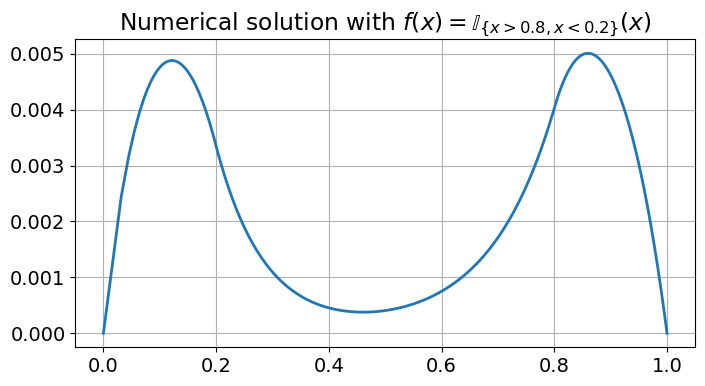

In [ ]:
# Litt morsom f som gir tolkning som "source term"
a,b,c = 1, -3, 100
f = lambda x : 1*(x>0.8) + 1*(x<0.2)
bvp = BVP(a, b, c, f=f)

# Solve with triangulation xk
xk = np.sqrt(np.linspace(0, 1, 1000))
U = FEM_solver(xk, bvp)

# Plot
plt.plot(xk, U)
#plt.plot(xk, f(xk), ls="--")
plt.title(r"Numerical solution with $f(x)=\mathbb{I}_{\{x>0.8, x<0.2\}}(x)$")
plt.savefig("Project2/problem2a_plot_a_solution", dpi=dpi)
plt.show()

## Problem 2b) Convergence experiment + Problem 2c) Error bound

We want the $H^1$ and $L^2$ errors. 

$$
    \lVert u \rVert_{H^1}^2 = \lVert u \rVert_{L^2}^2 + \lVert u_x \rVert_{L^2}^2
$$

Numerically, we compute the L2 norm with the trapezoidal rule.

When computing the $H^1$ norm in error analysis, it is important that we use interpolate some points between the nodes, since this is where our approximation is differentiable. 

We also want to see if the results are consistent with the theoretical bound found in the report:

$$
    \lVert  u-u_h\rVert_{H^1} \leq \sqrt{2} \frac{M}{k}\lVert u_{xx}\rVert_{L^2}h.
$$

Where:

$$
    M = (\lVert \alpha(x)\rVert_{L^\infty} + \lVert b(x)\rVert_{L^\infty} + c ) = a+b+c, \quad\quad
    k = \frac{2-\sqrt{2}}{2}\min\{\alpha_0, c_0\} =\frac{\sqrt{2}-1}{\sqrt{2}} \min\{a, c\}
$$

Rewriting to obtain:

$$
    \lVert  u-u_h\rVert_{H^1} 
    \leq \frac{2}{\sqrt{2}-1} \frac{a+b+c}{\min\{a,c\}}\lVert u_{xx}\rVert_{L^2} h
    = 2(\sqrt{2}+1) \frac{a+b+c}{\min\{a,c\}}\lVert u_{xx}\rVert_{L^2} h.
$$

In [ ]:
def L2(u,x):
    return np.sqrt(np.trapz(u**2, x))
  
def H1(u,x):
    return np.sqrt(L2(u, x)**2 + L2(np.gradient(u, x), x)**2)

def get_error_bound_const(bvp, u_man):
    x = np.linspace(0,1,100_000)
    uxx = np.gradient(np.gradient(u_man(x), x), x)
    return 2*(np.sqrt(2)+1)*(bvp.a+bvp.b+bvp.c)/(min(bvp.a, bvp.c))*L2(uxx, x)

In [ ]:
# Function operating a convergence study
def convergence_study(u_man, bvp : BVP, get_F):
    """
        u_man : manufactured solution function
        bvp : equation object
        get_F : method for computing load vector
    """ 

    M = 10 # initial number of gridpoints. M doubles each time
    P = 4  # number of refinements to perform experiment at

    step_sizes = np.zeros(P)
    error_L2   = np.zeros(P)
    error_H1   = np.zeros(P)

    for p in range(P):

        # Find approximated solution at nodes
        xk = np.linspace(0, 1, M+1)
        Uk = FEM_solver(xk, bvp, get_F=get_F)
        step_sizes[p] = xk[1]-xk[0]
        
        # To compare solutions, we need a better representation of our function
        # as a piecewice linear polynomial
        x = np.linspace(0, 1, 100*(M+1))
        U = np.interp(x, xk, Uk)
        error_L2[p] = L2(U-u_man(x), x)
        error_H1[p] = H1(U-u_man(x), x)

        M = 2*M

    p_L2 = np.polyfit(np.log(step_sizes),np.log(error_L2),1)[0]
    p_H1 = np.polyfit(np.log(step_sizes),np.log(error_H1),1)[0]
    
    # Prepare the table
    rate_L2     = np.zeros(np.size(error_L2))
    rate_L2[1:] = np.log10(error_L2[1:]/error_L2[:-1])/np.log10(step_sizes[1:]/step_sizes[:-1])
    rate_H1     = np.zeros(np.size(error_H1))
    rate_H1[1:] = np.log10(error_H1[1:]/error_H1[:-1])/np.log10(step_sizes[1:]/step_sizes[:-1])
    pd.options.display.float_format = '{:.5f}'.format
    df = pd.DataFrame(data={'h': step_sizes, 'L2': error_L2, 'rate L2' : rate_L2, 'H1' : error_H1, "rate H1" : rate_H1}) 

    return df, step_sizes, error_L2, error_H1, p_L2, p_H1

def plot_convergence_experiment_result(u_man, bvp, show_error=False, M=30, get_F=get_F_trapezoidal, error_bound_const=None):
    """
        u_man : manufactured solution function
        bvp : equation object
        show_error : wheter to include a plot of the error
        M : number of nodes in plotted solution
    """
    if show_error:
        fig, ax = plt.subplots(1, 4, figsize=(18,4))
    else:
        fig, ax = plt.subplots(1, 3, figsize=(14,4))

    # Add example
    xk = np.linspace(0, 1, M)
    u_num = FEM_solver(xk, bvp, get_F=get_F)
    ax[0].plot(xk, u_num, "r", label = "num")
    ax[0].plot(np.linspace(0,1,1_000), u_man(np.linspace(0,1,1_000)), "g--", label = "anal")
    ax[0].legend()
    ax[0].set_xlabel("x")
    ax[0].set_title(fr"Comparison for $M=${M}")

    # Add error
    if show_error:
        ax[1].plot(u_num - u_man(xk))
        ax[1].set_title("Error")

    # Add loglog and table
    df, step_sizes, error_L2, error_H1, p_L2, p_H1 = convergence_study(u_man, bvp, get_F)

    if error_bound_const:
        ax[-2].loglog(step_sizes, error_bound_const*step_sizes, label="Bound")
    ax[-2].loglog(step_sizes, error_L2, 'o-', label="p={:.2f}".format(p_L2) + r" in $L^2$")
    ax[-2].loglog(step_sizes, error_H1, 'o-', label="p={:.2f}".format(p_H1) + r" in $H^1$")
    ax[-2].grid('on')
    ax[-2].set_xlabel('h')
    ax[-2].set_ylabel('error')
    ax[-2].set_title("Error VS stepsize")
    ax[-2].legend()

    df = df.round(decimals=5)
    coll_labels = [r"$h$",r"$L^2$",r"rate",r"$H^1$",r"rate" ] #df.columns
    table = ax[-1].table(cellText=df.values, colLabels=coll_labels, colColours=["lightgrey"]*5, loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax[-1].set_title("Error table")
    ax[-1].axis('off')

    # Tight. save and show is done outside (:
    plt.tight_layout()

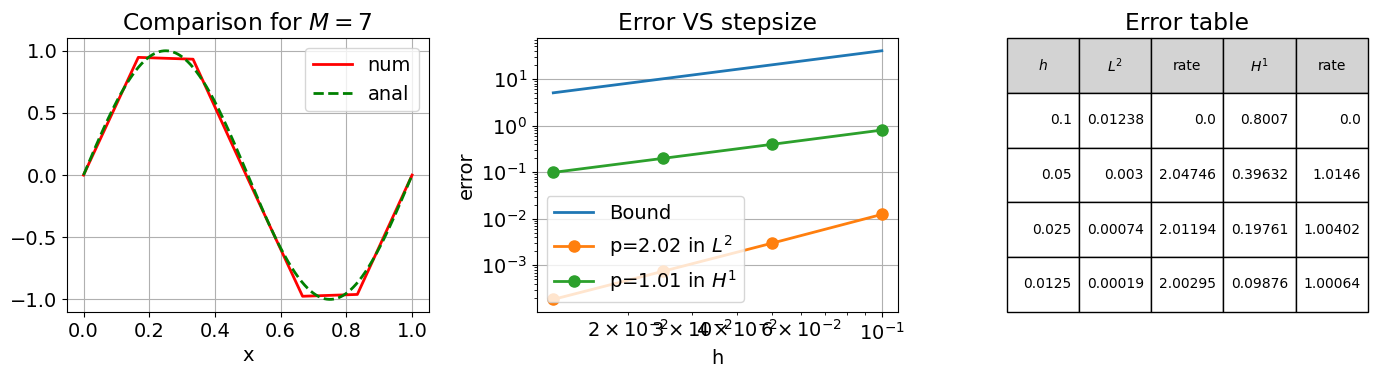

In [ ]:
# Manufacture a solution and make bvp object
u_man = lambda x : np.sin(2*np.pi*x)
def get_f_man(a, b, c):
    return lambda x : (c+a*4*np.pi**2)*u_man(x) + 2*np.pi*b*np.cos(2*np.pi*x)

a, b, c = 1, 1, 1
f_man = get_f_man(a, b, c)
bvp = BVP(a, b, c, ga=0, gb=0, f=f_man)

plot_convergence_experiment_result(u_man, bvp, show_error=False, M=7, error_bound_const=get_error_bound_const(bvp, u_man))
plt.savefig("Project2/convergence_sin", dpi=dpi)
plt.show()

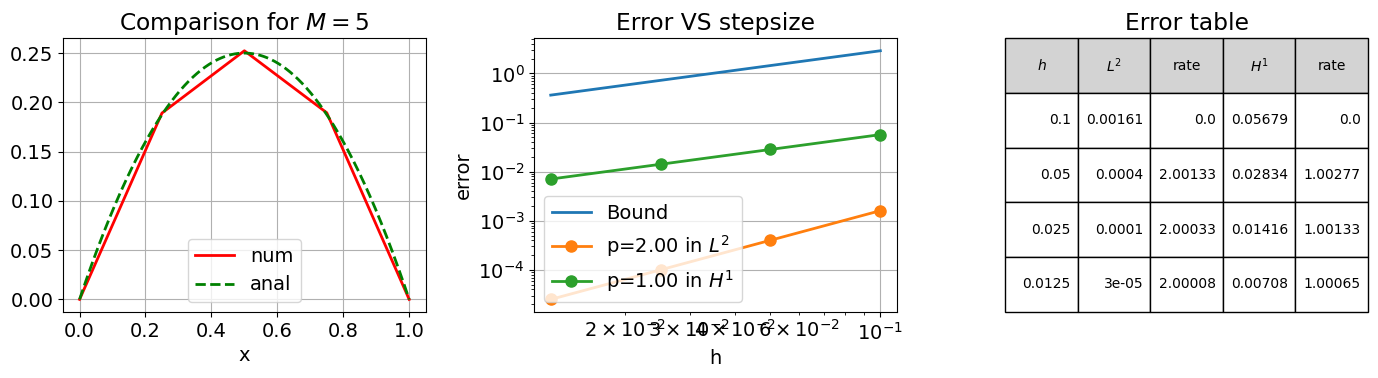

In [ ]:
# Manufacture a solution and make bvp object
u_man = lambda x : x*(1-x)
def get_f_man(a, b, c):
    return lambda x : 2*a+b*(1-2*x)+c*(x-x**2)

a,b,c = 1,1,1
f_man = get_f_man(a, b, c)
bvp = BVP(a, b, c, f=f_man)

plot_convergence_experiment_result(u_man, bvp, show_error=False, M=5, error_bound_const=get_error_bound_const(bvp, u_man))
plt.savefig("Project2/convergence_poly", dpi=dpi)
plt.show()

## Problem 2d) Non-smooth solutions

We consider 2 non-smooth manufactued solutions.

In [ ]:
# Our non-smooth manufactured solutions
w1 = lambda x : np.where(x < np.sqrt(2)/2, 2*x/np.sqrt(2), (1-x)/(1-np.sqrt(2)/2))
w2 = lambda x : x-x**(3/4)

# We need to define new method for F
def get_get_F_from_w(w_func):

    def get_F(xk, bvp):

        # Get equation constants
        a, b, c = bvp.a, bvp.b, bvp.c

        # Evaluate w in nodes and compute stepsize
        w = w_func(xk)
        h = np.array([None] + list(xk[1::] - xk[0:-1])) # Get nice indexing

        # Compute the load vector using trapezoidal rule on the integrals
        a_terms = +a*np.array([(w[i]-w[i-1])/h[i] - (w[i+1]-w[i])/h[i+1] for i in range(1, len(xk)-1)])
        b_terms = -b*np.array([(w[i]+w[i-1]-w[i+1]-w[i])/2 for i in range(1, len(xk)-1)])
        c_terms = +c*np.array([w[i]*(h[i]+ h[i+1])/2 for i in range(1, len(xk)-1)])

        return (a_terms+b_terms+c_terms)

    return get_F

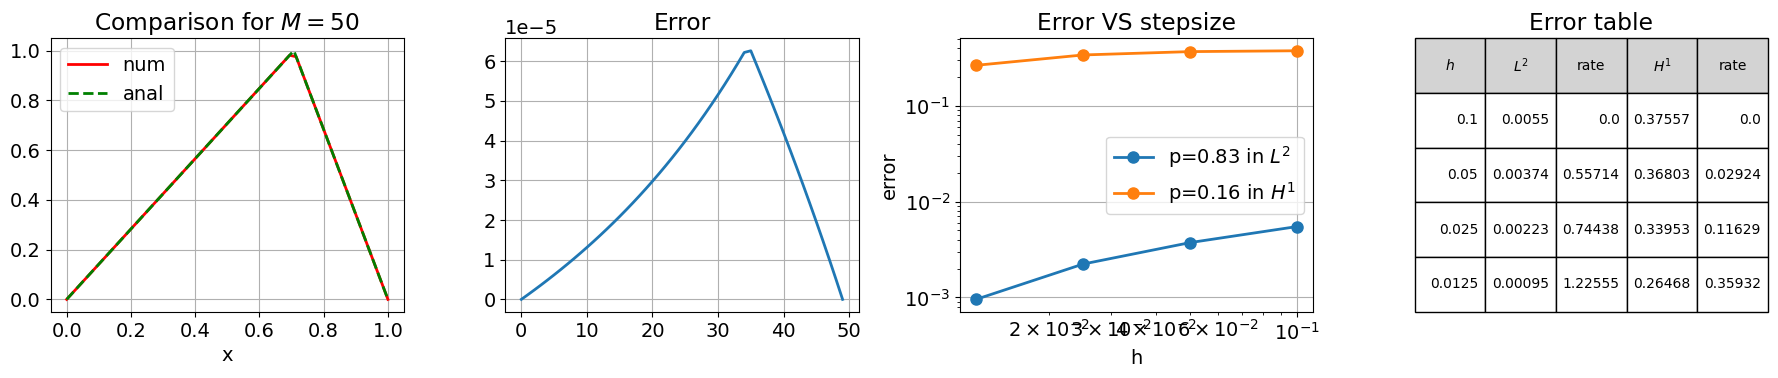

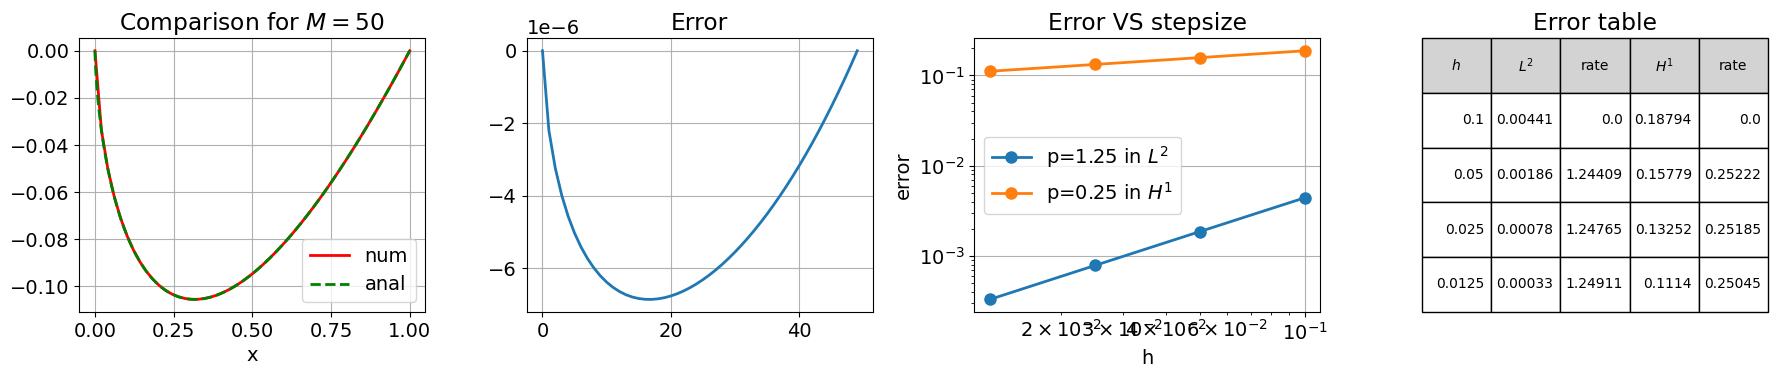

In [ ]:
a,b,c = 1,1,1
bvp = BVP(a, b, c, f=None) # No need for f with our new marvellous get_F function!
plot_convergence_experiment_result(w1, bvp, show_error=True, M=50, get_F=get_get_F_from_w(w1))
plt.savefig("Project2/2d)_w1", dpi=dpi)
plt.show()

a,b,c = 1,1,1
bvp = BVP(a, b, c, f=None) # No need for f with our new marvellous get_F function!
plot_convergence_experiment_result(w2, bvp, show_error=True, M=50, get_F=get_get_F_from_w(w2))
plt.savefig("Project2/2d)_w2", dpi=dpi)
plt.show()

## Problem 2e) Refined grid

We now consider righ-hand-sides 

$$
    f_1 = x^{-\frac{2}{5}} \quad f_2 = x^{-\frac{7}{5}}.
$$

Solutions are steap near $x=0$, so we introduce a graded grid with $M$ nodes and

$$
    x_0 = 0, \quad x_i = r^{M-i}, i=1,\dots,M.
$$

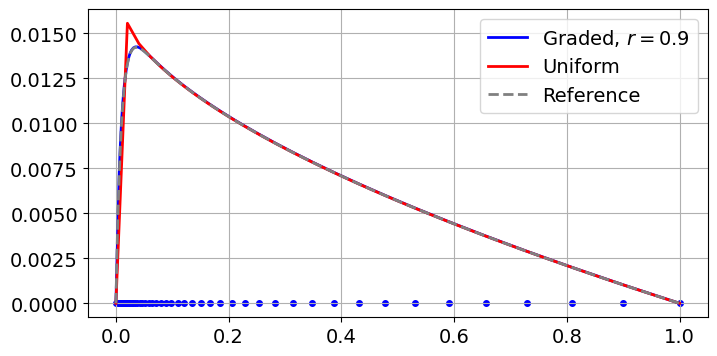

In [ ]:
### Define the functions
f1 = lambda x : x**(-2/5)
f2 = lambda x : x**(-7/5)

### Initial investigation ###
def problem_e(f, a, b, c, r):
    # Problem
    bvp = BVP(a, b, c, ga=0, gb=0, f=f)

    # Degrees of freedom (M segments, M+1 nodes)
    M = 50

    # Reference solution:
    xk_ref = np.linspace(0, 1, 1_000)
    uk_ref = FEM_solver(xk_ref, bvp)

    # Graded grid
    xk_graded = np.array([0] + [r**(M-i) for i in range(1, M+1)])
    uk_graded = FEM_solver(xk_graded, bvp)

    # Uniform grid
    xk_unif = np.linspace(0, 1, M)
    uk_unif = FEM_solver(xk_unif, bvp)

    # Plot
    plt.plot(xk_graded, uk_graded, label=fr"Graded, $r=${r}", color="blue")
    plt.scatter(xk_graded, 0*xk_graded, color="blue", marker=".")
    plt.plot(xk_unif, uk_unif, label="Uniform", color="red")
    plt.plot(xk_ref, uk_ref, label="Reference", color="gray", linestyle="--")
    plt.legend()
    plt.show()

a, b, c = 1, -100, 1
r = 0.9
problem_e(f1, a, b, c, r)

## Problem 2f) Optimal refined grid

Want to compare solution with uniform / graded grid.

<!-- Tabell struktur: 

| config   | H1 | L2 |
|----------|----------|----------|
|  uniform |  3 | 2  |
|  r = 0.8 |  ... |  ... |
|  r = 0.9 |  ... |  ... |
|  r = 0.95 |  ... |  ... |
|  ... |  ... |  ... | -->

We do the error study using a reference solution.


In [ ]:
def indeces_of_subarray(x_sub, x_sup, tol = 1e-10):
    """
        x_sub < x_sup is a subarray (up to some tolerance tol)
        finds the indeces of x_sup corresponding to elements of x_sub
    """
    indices = []
    for elem in x_sub:
        idx = np.argmin(np.abs(x_sup - elem))
        if np.abs(x_sup[idx] - elem) <= tol:
            indices.append(idx)
    return indices


def nodes_near_0_experiment(r_values, bvp, M, ref_size_multiplier=100, norm_size_multiplier=20):
    """
        r_values : list of r values
        bvp : equation object
        M : number of degrees of freedom / nodes
        ref_size_multiplier : ensure ref solution has at least this number * M points
        norm_size_multiplier : ensure this number minus 1 nodes between nodes when computing norms
    """
    # Uniform and graded grids + finer grids for error analysis
    xk_unif = np.linspace(0, 1, M)
    x_unif  = np.linspace(0, 1, norm_size_multiplier*M)

    xk_graded_list = [np.array([0] + [r**(M-i-1) for i in range(1, M)]) for r in r_values]
    x_graded_list = [np.hstack([np.linspace(a, b, norm_size_multiplier)[:-1] for a, b in zip(arr, arr[1:])]) for arr in xk_graded_list]

    # Reference solution. We must solve with a grid containing all the nodes!
    # It most also include all the values between the nodes that we use for interpolation
    x_ref = list(np.linspace(0, 1, ref_size_multiplier*M)) # Ensure a lot more than M points
    x_ref += list(x_unif)
    for x in x_graded_list:
        x_ref += list(x)
    x_ref = np.sort(np.array(list(set(x_ref))))
    u_ref = FEM_solver(x_ref, bvp)

    # Uniform error
    uk_unif = FEM_solver(xk_unif, bvp)
    u_unif = np.interp(x_unif, xk_unif, uk_unif)
    L2_unif = L2(u_ref[indeces_of_subarray(x_unif, x_ref)]-u_unif, x_unif)
    H1_unif = H1(u_ref[indeces_of_subarray(x_unif, x_ref)]-u_unif, x_unif)

    # Graded grid
    L2_graded_list = []
    H1_graded_list = []
    u_graded_list = []
    uk_graded_list = []
    for (xk_graded, x_graded) in zip(xk_graded_list, x_graded_list):
        uk_graded = FEM_solver(xk_graded, bvp)
        u_graded = np.interp(x_graded, xk_graded, uk_graded)

        L2_graded_list.append(L2(u_ref[indeces_of_subarray(x_graded, x_ref)]-u_graded, x_graded))
        H1_graded_list.append(H1(u_ref[indeces_of_subarray(x_graded, x_ref)]-u_graded, x_graded))
        uk_graded_list.append(uk_graded)
        u_graded_list.append(u_graded)

    ### Make figure ###    
    fig, ax = plt.subplots(1, 3, figsize=(14,4))

    # Add the best example
    idx = np.argmin(np.array(L2_graded_list))
    ax[0].plot(xk_graded_list[idx], uk_graded_list[idx], label=fr"Graded, $r=${r_values[idx]}", color="blue")
    ax[0].plot(xk_unif, uk_unif, label="Uniform", color="red")
    ax[0].plot(x_ref, u_ref, label="Reference", color="gray", linestyle="--")
    ax[0].scatter(xk_graded_list[idx], M*[0], label="Grid", color="blue", marker=".", s=20)
    ax[0].legend()
    ax[0].set_xlabel(r"$x$")
    ax[0].set_title(fr"Comparison for $L^2$ optimal $r$")

    ax[1].plot(r_values, L2_graded_list, 'o-', label=r"$L^2$", color="blue")
    ax[1].plot(r_values, [L2_unif for i in range(len(r_values))], linestyle='-', color="red")#, label=r"$L^2$ uniform")
    ax[1].plot(r_values, H1_graded_list, 'o--', label=r"$H^2$", color="blue")
    ax[1].plot(r_values, [H1_unif for i in range(len(r_values))], linestyle='--', color="red")#, label=r"$H^1$ uniform")
    ax[1].set_xlabel(r'$r$')
    ax[1].set_ylabel('error')
    ax[1].set_title(r"Error VS $r$")
    ax[1].set_yscale("log")
    ax[1].legend()

    dec = 4
    col_labels = ["Grid", r"$L^2$", r"$H^1$"]
    data = [["Uniform", round(L2_unif, dec), round(H1_unif, dec)]] + [[fr"r={r_values[i]}", round(L2_graded_list[i], dec), round(H1_graded_list[i], dec)] for i in range(len(r_values))]
    table = ax[-1].table(cellText=data, colLabels=col_labels, colColours=["lightgrey"]*3, loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    ax[2].set_title("Error table")
    ax[2].axis('off')

    # Tight. save and show is done outside (:
    plt.tight_layout()

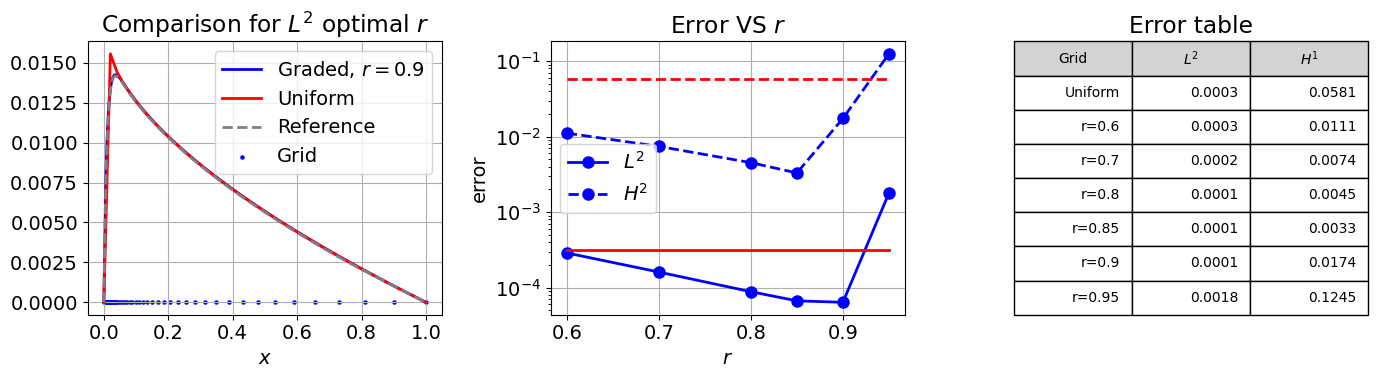

In [ ]:
# Problem
a, b, c = 1, -100, 1
bvp = BVP(a, b, c, ga=0, gb=0, f=f1)

# Degrees of freedom
M = 50
nodes_near_0_experiment([0.6, 0.7, 0.8, 0.85, 0.9, 0.95], bvp, M, 100, 10)
plt.savefig("Project2/2f)_f1", dpi=dpi)
plt.show()

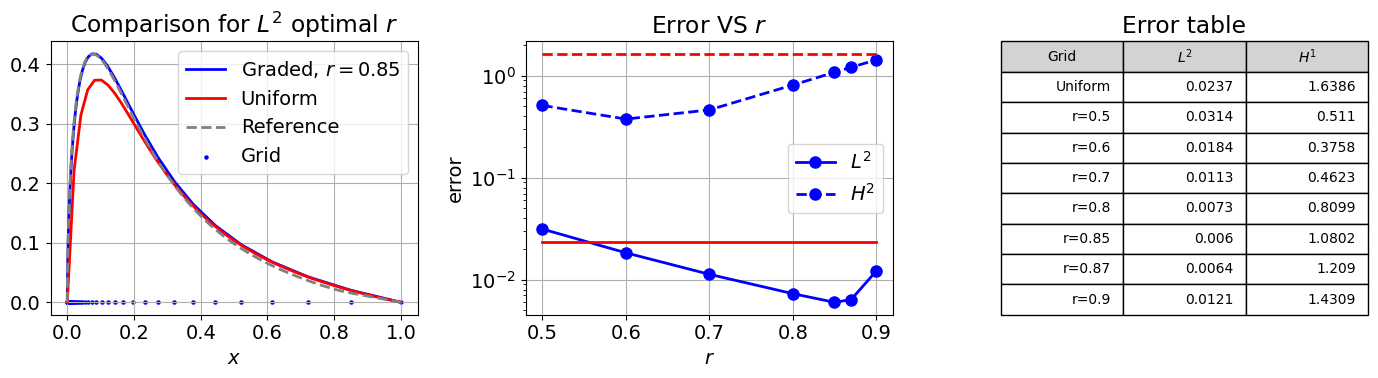

In [ ]:
# Problem
a, b, c = 1, -10, 1
bvp = BVP(a, b, c, ga=0, gb=0, f=f2)

# Degrees of freedom
M = 50
nodes_near_0_experiment([0.5, 0.6, 0.7, 0.8, 0.85, 0.87, 0.9], bvp, M, 100, 10)
plt.savefig("Project2/2f)_f2", dpi=dpi)
plt.show()

The derivative affects the L2 norm. It suffers a lot for the uniform approach, as we get a poor appriximation of a very steep curve. 

Also see that the optimal $r$ for $H^2$ is lower. This is again due to the steep derivative not noticed as much by $L^1$.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=42426271-88a7-4adc-ba0e-a178b326bae7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>